# Speckle pattern generator
This code generates dynamic speckle patterns at the end facet of a multimode fiber (MMF),
which can be used as the mask patterns for single-pixel imaging.

When phase-modulating the input electric field with $u(t)$,
the electric field $E(x,y,L,t)$ at the end of an MMF is given by

$E(x,y,L,t) = \sum_{m=0}^M e^{-i\beta_m L}e^{i\alpha u(t-\tau_m)}\Psi_m(x,y),$

where $\Psi_m$, $\beta_m$, and $\tau_m$ represent the wave function, propagation constant, and time delay for the $m$-th propagating modes in the MMF, the length of which is denoted by $L$.

#The important parameters
fiber_length: MMF fiber length

width: MMF fiber width (assuming squared core)

lw0: Input light's wavelenth

num_x_pixel, num_y_pixel: Number of spatial sampling at the x- and y- axes

dx, dy: the spatial resolution

Input signal parameters

time_length: Time length of input signal

# Output

Mask pattern(x,y,t) = $|E(x,y,L,t)|^2$ at time $t$ and at the $xy$ position.

# How to use for single pixel imaging
Let us suppose that we observe an image, represented by $Image$, using a single photodetector and mask patterns, denoted by $Mask$.
In this setup, the measured signal is a time-sequence, i.e., the visual information, e.g., the image, is converted to a time sequence.

The detected signal $y(t)$ at time $t$ is expressed by

$y(t) = \sum_{i,j}Mask(x_i,y_j)Image(x_i,y_j).$

What we want to do is to reconstruct the image $Image$ from the measured sequence, $y(t)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#####################################
# Set parameters
#####################################
fiber_length = 20       # Fiber length (m)
width        = 200e-6    # Fiber core width  (m)
nref         = 1.4611   # Fiber refractive index
na           = 0.39     # N.A.

lw0    = 1550.0e-9       # center wavelgnth (m)
c      = 3.0e8           # light velocity (m/s)
omega0 = 2.0*np.pi*c/lw0 # angular frequency (rad/s)
kw     = omega0/c        # wavenumber (1/m)

####### Spatial sampling ###
num_x_pixel = 28
num_y_pixel = 28
dx          = width/num_x_pixel
dy          = width/num_y_pixel
x           = np.arange(1,num_x_pixel+1)*dx
y           = np.arange(1,num_y_pixel+1)*dy

####### Input signal ######
time_length  = 784           # Time length of input signal
dt_w         = 0.04e-9        # Time interval of input signal (s)
dt_samp      = 0.02e-9        # Sampling time interval (s)
al           = 2.0*np.pi      # Input signal amplitude
num_repeat   = int(dt_w/dt_samp)  # number of repeat

######################################
# Fixed parameters
######################################


#----------- Multimode fiber --------------
V_number     = (np.pi*width/lw0)*na      # normalized frequency
num_sq_modes = int( np.sqrt(0.5*V_number*V_number) )
num_modes    = num_sq_modes*num_sq_modes # num. of excited modes

# xy wavenumbers
kx = np.linspace(1,num_sq_modes,num_sq_modes)*(np.pi/width)
ky = np.linspace(1,num_sq_modes,num_sq_modes)*(np.pi/width)

# beta wavenumbers & mode patterns
_beta = np.zeros(num_modes)
_psi  = np.zeros((num_modes,num_x_pixel,num_y_pixel))
for i in range(num_sq_modes):
    for j in range(num_sq_modes):
        m = num_sq_modes*i + j
        _beta[m] = np.sqrt( nref*nref*kw*kw - kx[i]*kx[i] - ky[j]*ky[j] )
        _psi[m,:,:] = np.matmul( np.array([np.sin(kx[i]*x),]).T, np.array([np.sin(ky[j]*y),]) )

# sorting
beta = np.sort(_beta)
psi  = _psi[np.argsort(_beta),:,:]

# dispersion, d\beta/d\omega
disp       = ((nref*nref)/(c*c))*omega0/beta
# time delay
time_delay =  disp*fiber_length
# relative time delay
relative_time_delay = time_delay - time_delay[0]
# index
i_delay = relative_time_delay/dt_samp
i_delay = i_delay.astype(int)

# mode amplitudes
aa = np.random.uniform(-1.0,1.0,num_modes)+1j*np.random.uniform(-1.0,1.0,num_modes)
aa = aa*np.exp(1j*beta*fiber_length)

# Input signal
_uu = np.random.uniform(-1.0,1.0,int(time_length/num_repeat) )
uu  = al*np.repeat(_uu,num_repeat)

# time delay
uu_delay = np.zeros((num_modes,time_length))
for m in range(num_modes):
    uu_delay[m] = np.roll(uu,i_delay[m])
# phase modulated input singal
phase_modulated_input = np.exp(1j*uu_delay)

# speckle field
mask_speckles = np.zeros((time_length,num_x_pixel,num_y_pixel))*1j
for n in tqdm( range(time_length) ):
    for m in range(num_modes):
        mask_speckles[n,:,:] += aa[m]*psi[m,:,:]*phase_modulated_input[m,n]

mask_patterns = np.abs(mask_speckles)**2
mask_patterns = mask_patterns.astype(float)

100%|██████████| 784/784 [01:35<00:00,  8.24it/s]


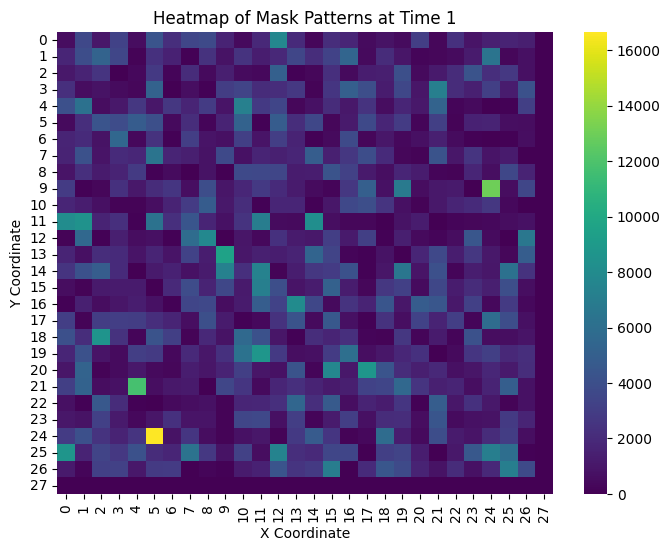

In [6]:
import seaborn as sns

# 特定の時刻のデータを選択しヒートマップとして表示
t = 1  # 可視化したい時刻を選択
plt.figure(figsize=(8, 6))
sns.heatmap(mask_patterns[t, :, :], cmap="viridis")
plt.title(f"Heatmap of Mask Patterns at Time {t}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
# plt.colorbar(label="Pattern Value")
plt.show()

In [7]:
mask_patterns = mask_patterns/np.mean(mask_patterns)

# View: Spatial distribution of Generated speckle patterns at time t

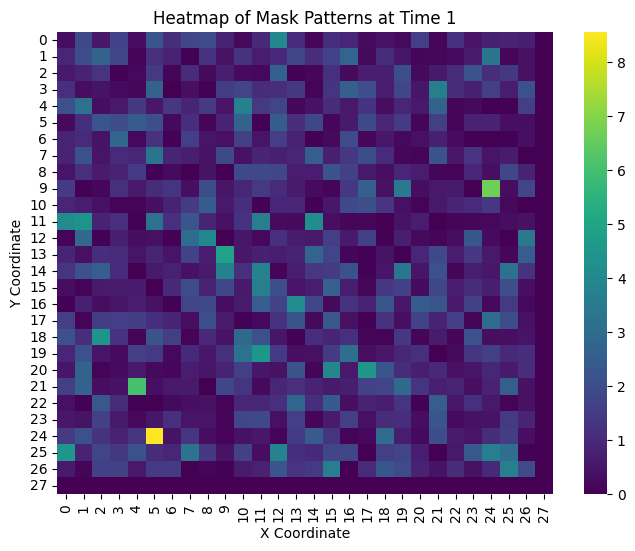

In [8]:
import seaborn as sns

# 特定の時刻のデータを選択しヒートマップとして表示
t = 1  # 可視化したい時刻を選択
plt.figure(figsize=(8, 6))
sns.heatmap(mask_patterns[t, :, :], cmap="viridis")
plt.title(f"Heatmap of Mask Patterns at Time {t}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
# plt.colorbar(label="Pattern Value")
plt.show()

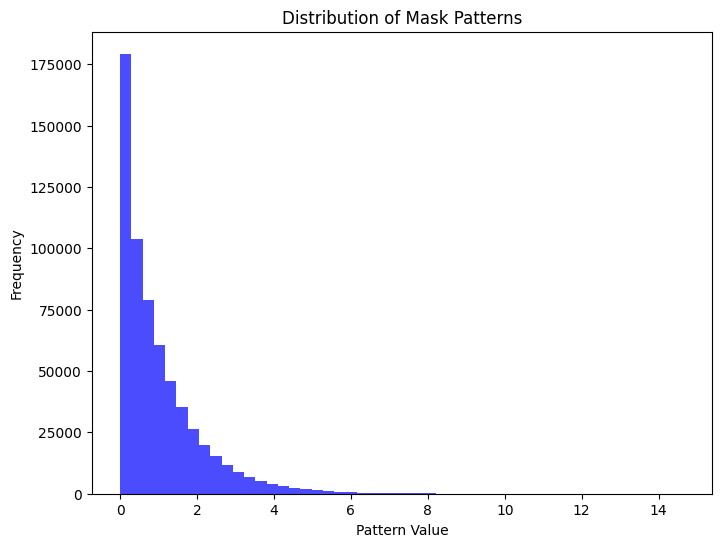

In [9]:
# すべての時刻、空間座標にわたる値を1つの配列に変換
data = mask_patterns.flatten()

# ヒストグラムをプロット
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Mask Patterns")
plt.xlabel("Pattern Value")
plt.ylabel("Frequency")
plt.show()

# View: Generated speckle patterns (used for Mask patterns)

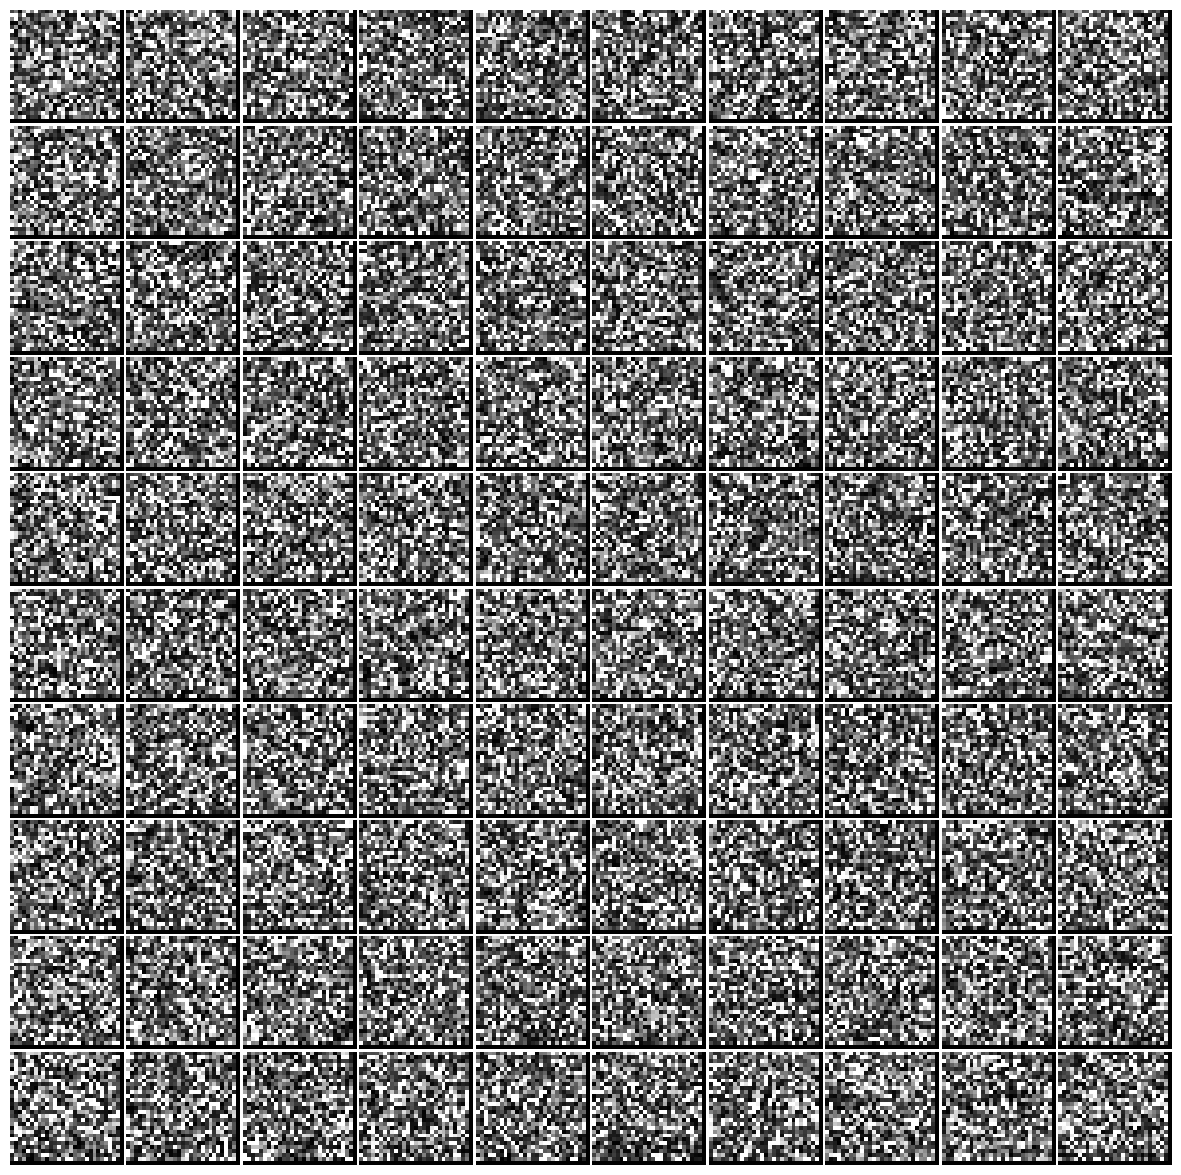

In [ ]:
nnx = 10
nny = int(time_length/nnx)
fig, axes = plt.subplots(nny,nnx, figsize = (15,15))
for n, ax in enumerate(axes.flat):
#    ax.set_title(str(n))
    ax.imshow(mask_patterns[n],cmap="gray",vmin=0,vmax=2)
    ax.axis("off")
plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.show()

In [ ]:
mask_patterns[1][:, 28]

array([7.92572653e-29, 8.30758920e-28, 6.36669283e-28, 3.52658856e-28,
       9.23925447e-28, 4.24508065e-28, 1.28962340e-27, 4.66045069e-28,
       6.09700645e-28, 1.77209026e-28, 3.24436912e-29, 1.85776315e-27,
       9.80216389e-29, 2.15727758e-27, 3.23625024e-29, 1.60155291e-28,
       3.65863624e-29, 3.18399451e-28, 2.75140689e-27, 3.51074149e-28,
       4.48783900e-28, 1.21783145e-28, 1.01924026e-27, 1.99146207e-27,
       8.19192481e-28, 1.04181364e-27, 8.57537246e-28, 2.16340927e-27,
       6.56904791e-55])

# Check: Spatial correlation
measures the correlation value between speckle patterns and plots a correlation matrix.

100%|██████████| 100/100 [00:00<00:00, 143.35it/s]


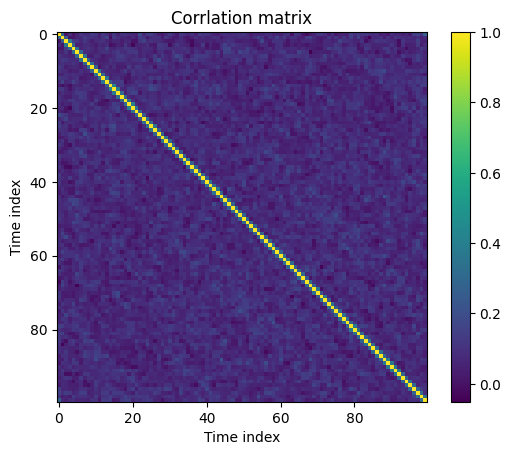

In [ ]:
corr = np.zeros((time_length,time_length))
for n0 in tqdm( range(time_length) ):
    for n1 in range(time_length):
        corr[n0,n1] = np.corrcoef(mask_patterns[n0].reshape(num_x_pixel*num_y_pixel),mask_patterns[n1].reshape(num_x_pixel*num_y_pixel))[0,1]

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.set_title("Corrlation matrix")
ax.set_xlabel("Time index")
ax.set_ylabel("Time index")
cc = ax.imshow(corr)
fig.colorbar(cc)
plt.show()

# others

In [ ]:
mask_patterns.shape

(784, 29, 29)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
!ls

'Colab Notebooks'   original_mnist_image10x100_resize16x16_alternate.npz   Untitled0.ipynb
 comparison.xlsx    original_mnist_image10x100_resize8x8_alternate.npz	   wandb
 loss_total.npy     RC_target_total.npy					   wandb.ipynb
 mps		    simulate_SP


In [ ]:
mnist_data = np.load("Colab Notebooks/research/class10_image10x1000.npz")["arr_0"]
mnist_data = mnist_data / 255.0
print(mnist_data.shape)

(10000, 784)


In [ ]:
mask_patterns = mask_patterns[:, :28, :28]

In [ ]:
mask_patterns.shape

(784, 28, 28)

In [ ]:
mask_reshape = mask_patterns.reshape(784, 28*28)
print(mask_reshape.shape)

(784, 784)


In [ ]:
trans_mask = mask_reshape.T
print(trans_mask.shape)

(784, 784)


In [ ]:
y_sequence = np.dot(mnist_data,trans_mask)
print(y_sequence.shape)

(10000, 784)


In [ ]:
y_sequence

array([[ 92.13244972, 107.96575547, 111.23167801, ...,  92.7040213 ,
        113.47712688, 104.11827264],
       [ 55.60752738,  58.91850044,  57.30588571, ...,  53.59182056,
         50.19566486,  51.67297442],
       [ 96.8665559 , 107.23343019, 120.66431537, ..., 107.56750042,
        126.41291024, 112.39229087],
       ...,
       [ 95.77155429, 106.466553  , 133.18512853, ..., 108.98926348,
        122.17308312, 122.61794351],
       [ 63.53183931,  81.14171234,  68.2439897 , ...,  66.15217211,
         65.56979705,  73.82504252],
       [ 86.50876228,  91.55807008,  83.96622116, ...,  91.82865014,
        108.83371793,  96.14342184]])

# torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
class Net_version_1(nn.Module):
    def __init__(self):
        super(Net_version_1, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 784)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return x

In [ ]:
class UNet_ver2(nn.Module):
    """
    Unet-based original model
    """

    def __init__(self):
        super(UNet_ver2, self).__init__()
        # Encoder
        self.down1 = self.down_sample(1, 32)
        self.down2 = self.down_sample(32, 64)
        self.down3 = self.down_sample(64, 128)

        # Decoder
        self.up3 = self.up_sample(128, 64)
        self.up2 = self.up_sample(128, 32)
        self.up1 = self.up_sample(64, 16)
        self.fc = nn.Sequential(
            nn.Linear(16 * 784, 2048),
            # nn.LeakyReLU(0.2),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            # nn.LeakyReLU(0.2),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def down_sample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def up_sample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, 500)
        # print(x.shape)
        # Encoder
        d1 = self.down1(x)  # (batch_size, 32, 250)
        # print(d1.shape)
        d2 = self.down2(d1)  # (batch_size, 64, 125)
        # print(d2.shape)
        d3 = self.down3(d2)  # (batch_size, 128, 63)
        # print(d3.shape)
        # Decoder
        u3 = self.up3(d3)  # (batch_size, 64, 126)
        # print(u3.shape)
        u3 = torch.cat([u3[:, :, :196], d2], dim=1)  # (batch_size, 128, 125)
        # print(u3.shape)
        u2 = self.up2(u3)  # (batch_size, 32, 250)
        # print(u2.shape)
        u2 = torch.cat([u2, d1], dim=1)  # (batch_size, 64, 250)
        # print(u2.shape)
        u1 = self.up1(u2)  # (batch_size, 16, 500)
        # print(u1.shape)
        # Flatten and pass through fully connected layers
        out = self.fc(u1.view(u1.size(0), -1))  # (batch_size, 64)
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = UNet_ver2()
data = torch.randn(1, 784)
print(data.shape)
output = model(data)
print(output.shape)
model.to(device)
print(model)

torch.Size([1, 784])
torch.Size([1, 784])
UNet_ver2(
  (down1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (down2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (down3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (up3): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
def normal_loss(y_pred, y_true, S):
    # Calcurate y from predicted x and S
    reconstructed_y = torch.mm(y_pred.unsqueeze(0), S).squeeze(0)
    # Calculate MSE loss at original scale
    loss = F.mse_loss(reconstructed_y, y_true)
    return loss

In [ ]:
######################################################
# Training function
######################################################
def train_model(
    model: nn.Module,
    speckle: torch.Tensor,
    input_data: torch.Tensor,
    num_epochs: int,
    learning_rate: float,
):
    model.to(device)
    input_data = input_data.to(device)
    speckle = speckle.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    # optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

    loss_list = []
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        reconstructed_mnist = model(input_data.unsqueeze(0)).squeeze(0)
        loss = normal_loss(reconstructed_mnist, input_data, speckle)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")
    model.eval()
    with torch.no_grad():
        reconstucted_target = model(input_data.unsqueeze(0)).squeeze(0)

    return loss_list, reconstucted_target

In [ ]:
def main_train(
    model,
    num_images: int,
    num_epochs: int,
    data_y: np.ndarray,
    S: np.ndarray,
    normalized,
    learning_rate,
):
    """
    メイン訓練ループ

    Args:
        num_images: 画像枚数
        num_epochs: 各画像のエポック数
        data_y: 観測データY
        S: スペックル
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    S_tensor = torch.tensor(S).float().to(device)
    # model = Net_version_1()
    model = model

    loss_total = []
    reconstructed_total = []
    for i in range(num_images):
        y_observed = torch.tensor(data_y[i]).float().to(device)
        loss_list, reconstructed_x = train_model(
            model,
            S_tensor,
            y_observed,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
        )
        loss_total.append(loss_list)
        reconstructed_total.append(reconstructed_x.cpu().numpy())
        # if i == 0 or (i + 1) % 100 == 0:
        print(
            f"Iteration: {i+1}/{num_images}, Final Loss: {loss_list[-1]:.4f}"
        )
    return loss_total, reconstructed_total

In [ ]:
# selected_model = Net_version_1()
selected_model = UNet_ver2()
normalized = False
num_epochs = 5000
learning_rate = 1e-4
yy = y_sequence
speckle = trans_mask
num_images=10

In [ ]:
loss_history, reconstructed_signals = main_train(
        selected_model,
        num_images,
        num_epochs,
        yy,
        speckle,
        normalized,
        learning_rate,
    )

Epoch: [100/5000], Loss: 61.175545
Epoch: [200/5000], Loss: 40.587116
Epoch: [300/5000], Loss: 32.450523
Epoch: [400/5000], Loss: 316.057068
Epoch: [500/5000], Loss: 37.935539
Epoch: [600/5000], Loss: 34.466145
Epoch: [700/5000], Loss: 75.587662
Epoch: [800/5000], Loss: 91.748749
Epoch: [900/5000], Loss: 321.363525
Epoch: [1000/5000], Loss: 146.813217
Epoch: [1100/5000], Loss: 33.208054
Epoch: [1200/5000], Loss: 67.799934
Epoch: [1300/5000], Loss: 74.011322
Epoch: [1400/5000], Loss: 53.698051
Epoch: [1500/5000], Loss: 30.241774
Epoch: [1600/5000], Loss: 19.875378
Epoch: [1700/5000], Loss: 25.340147
Epoch: [1800/5000], Loss: 30.215919
Epoch: [1900/5000], Loss: 98.881966
Epoch: [2000/5000], Loss: 31.570118
Epoch: [2100/5000], Loss: 28.193836
Epoch: [2200/5000], Loss: 140.547455
Epoch: [2300/5000], Loss: 29.917261
Epoch: [2400/5000], Loss: 23.411755
Epoch: [2500/5000], Loss: 26.502222
Epoch: [2600/5000], Loss: 70.633438
Epoch: [2700/5000], Loss: 32.342293
Epoch: [2800/5000], Loss: 46.6007

In [ ]:
print("Training completed.")
print(f"Final average loss: {np.mean([loss[-1] for loss in loss_history]):.4f}")
nd_recon = np.array(reconstructed_signals)

Training completed.
Final average loss: 47.8234


In [ ]:
normalized_recon = (nd_recon + 1) / 2
normalized_recon
# ステップ2: 0～255の輝度値に変換
final_recon = (normalized_recon * 255).astype(np.uint8)

In [ ]:
final_recon[0]

array([246, 209, 136, 239,  15,  12, 135, 249,   1, 152,  54,   1,   8,
       232, 200, 102,  12, 253,  15, 229,   5,  72,  20,  20, 191, 249,
       205,  16,   3, 221, 251,   3,   0, 159,  36,  64, 134,   6,  18,
       122, 234, 171, 252,  94,   0,  72, 148, 125, 254,  64,   8, 244,
        31, 252, 151, 244,   7,  24, 250, 242, 167,  27, 128, 151,  85,
         1,   4, 248, 246, 246,   4, 254,  12,  19, 205,  67, 236, 252,
        80,   1, 223,   8, 229, 248,   9, 209, 253,   1,   2,   8,   1,
       200,  34, 254, 254, 232, 143, 129, 120, 159,  34, 192,   5,   6,
       250, 249,  22, 199, 251,   1,  45, 210,  10, 108,  89, 193,  74,
       223, 118, 252, 141, 165,  14,  14, 220,  63, 234, 103,   1,  18,
       240, 252,  13, 253, 144, 110, 205,   3,  36,   3, 252, 129, 111,
         1, 223, 240, 128,  81,  45,  17, 243, 187, 251, 251, 247,   2,
       250,  47, 249, 247,  20,  17, 241,  62,  29, 243, 146, 253, 112,
       183,   3, 204, 249,  71,   9, 253, 250, 235, 253, 251, 15

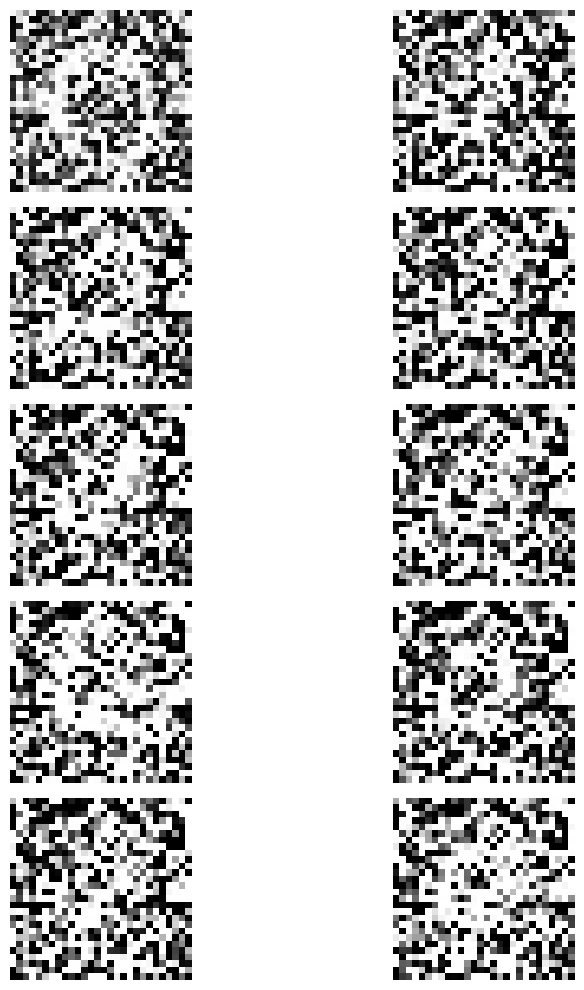

In [ ]:
# 表示する画像の数
num_images = nd_recon.shape[0]  # 例としてnd_reconは画像データ (N, 784) の形

# 何行何列で表示するか決める (例として5行5列に設定)
rows = 5
cols = 2

# プロットのサイズを調整
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# 全てのサブプロットに画像を表示
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]  # サブプロットの位置を計算
    ax.imshow(final_recon[i, :].reshape(28, 28), cmap="gray")
    ax.axis("off")  # 軸を非表示にする

# プロットを表示
# plt.Colorbar()
plt.tight_layout()
plt.show()

In [ ]:
def image_display(j, xx, yy, size=28):
    print("MSE =", mean_squared_error(xx, yy))
    print("SSIM =", calculate_average_ssim(xx, yy, num_images=10))
    fig = plt.figure(figsize=(4, 4 * j))
    for i in range(j):
        ax1 = fig.add_subplot(j, 2, i * 2 + 1)
        ax2 = fig.add_subplot(j, 2, i * 2 + 2)

        ax1.set_title("Target_image")
        ax2.set_title("Reconstruction")

        ax1.imshow(xx[i, :].reshape(size, size), cmap="gray")
        ax2.imshow(yy[i, :].reshape(size, size), cmap="gray")
    plt.show()

In [ ]:
def ssim_normalized(img1, img2, window_size=3):
    """
    Calculate SSIM for images normalized to [-1, 1] range with size 8x8.

    Args:
    img1, img2 (torch.Tensor): Input images with shape [batch_size, channels, 8, 8]
    window_size (int): Size of the sliding window. Default is 3.

    Returns:
    torch.Tensor: SSIM value
    """
    # Constants
    C1 = (0.01 * 2)**2  # 2 is the range of the pixels
    C2 = (0.03 * 2)**2

    # Check input
    assert img1.shape == img2.shape == (1, 1, 28, 28), "Input images must be 8x8"
    assert torch.min(img1) >= -1 and torch.max(img1) <= 1, "Image values should be in [-1, 1]"
    assert torch.min(img2) >= -1 and torch.max(img2) <= 1, "Image values should be in [-1, 1]"

    # Generate Gaussian kernel
    kernel = torch.ones((1, 1, window_size, window_size)) / (window_size ** 2)
    kernel = kernel.to(img1.device)

    # Compute means
    mu1 = F.conv2d(img1, kernel, padding=window_size//2, groups=1)
    mu2 = F.conv2d(img2, kernel, padding=window_size//2, groups=1)

    # Compute squares
    mu1_sq, mu2_sq = mu1.pow(2), mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    # Compute variances and covariance
    sigma1_sq = F.conv2d(img1 * img1, kernel, padding=window_size//2, groups=1) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, kernel, padding=window_size//2, groups=1) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, kernel, padding=window_size//2, groups=1) - mu1_mu2

    # Compute SSIM
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean()

def calculate_average_ssim(XX, nd_recon, num_images=10):
    ssim_values = []
    for i in range(num_images):
        img1 = torch.tensor(XX[i].reshape(1, 1, 28, 28)).float()
        img2 = torch.tensor(nd_recon[i].reshape(1, 1, 28, 28)).float()
        ssim_val = ssim_normalized(img1, img2)
        ssim_values.append(ssim_val.item())
        print(f"SSIM for image {i}: {ssim_val:.4f}")

    average_ssim = sum(ssim_values) / len(ssim_values)
    return average_ssim

In [ ]:
mnist_data_10 = mnist_data[:10, :]
mnist_data_10.shape

(10, 784)

In [ ]:
mnist_data_10[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
final_recon[0]

array([246, 209, 136, 239,  15,  12, 135, 249,   1, 152,  54,   1,   8,
       232, 200, 102,  12, 253,  15, 229,   5,  72,  20,  20, 191, 249,
       205,  16,   3, 221, 251,   3,   0, 159,  36,  64, 134,   6,  18,
       122, 234, 171, 252,  94,   0,  72, 148, 125, 254,  64,   8, 244,
        31, 252, 151, 244,   7,  24, 250, 242, 167,  27, 128, 151,  85,
         1,   4, 248, 246, 246,   4, 254,  12,  19, 205,  67, 236, 252,
        80,   1, 223,   8, 229, 248,   9, 209, 253,   1,   2,   8,   1,
       200,  34, 254, 254, 232, 143, 129, 120, 159,  34, 192,   5,   6,
       250, 249,  22, 199, 251,   1,  45, 210,  10, 108,  89, 193,  74,
       223, 118, 252, 141, 165,  14,  14, 220,  63, 234, 103,   1,  18,
       240, 252,  13, 253, 144, 110, 205,   3,  36,   3, 252, 129, 111,
         1, 223, 240, 128,  81,  45,  17, 243, 187, 251, 251, 247,   2,
       250,  47, 249, 247,  20,  17, 241,  62,  29, 243, 146, 253, 112,
       183,   3, 204, 249,  71,   9, 253, 250, 235, 253, 251, 15

MSE = 0.7045685872978221
SSIM for image 0: 0.0618
SSIM for image 1: 0.0185
SSIM for image 2: 0.0425
SSIM for image 3: 0.0189
SSIM for image 4: 0.0330
SSIM for image 5: 0.0270
SSIM for image 6: 0.0446
SSIM for image 7: 0.0258
SSIM for image 8: 0.0270
SSIM for image 9: 0.0528
SSIM = 0.03519713468849659


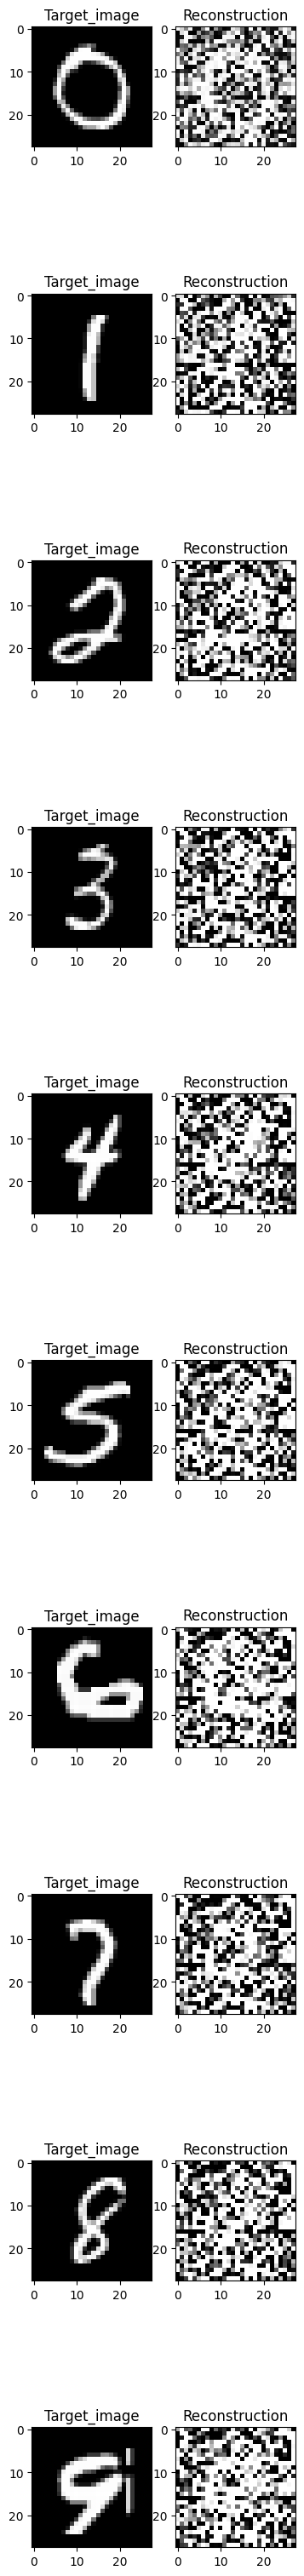

In [ ]:
image_display(10, mnist_data_10, nd_recon, size=28)